In [1]:
#https://aidanrussellcom.wordpress.com/2019/01/14/pystan-tutorial-1/

In [2]:
# TODO try larger dataset

In [3]:
import numpy as np
import pandas as pd
import stan as ps
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from utils import get_data
np.random.seed(2024)
train, test = get_data(filepath="processed_data/full_data_secs.csv", size_train=1000, size_test=800)
# train = train[train["dist"] == "10K"]

# train["prop2"] = np.exp(train["prop"])
# test["prop2"] = np.exp(test["prop"])

train["propleft"] = 1 - train["prop"]
test["propleft"] = 1 - test["prop"]
train.to_csv("train.csv")
test.to_csv("test.csv")

In [4]:
import pandas as pd
marks = ["5K", "10K", "15K", "20K", "25K", "30K", "35K", "40K"]
stan_results1 = pd.read_csv("stan_results/bayes1/ps_result.csv")
stan_results2 = pd.read_csv("stan_results/bayes2/ps_result.csv")

r_results1 = pd.read_csv("stan_results/bayes1/rs_result.csv")
r_results2 = pd.read_csv("stan_results/bayes2/rs_result.csv")

r_results2.describe()

,Unnamed: 0,alpha,beta[1],beta[2],beta[3],sigma,lp__
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,2000.500000,-0.261962,0.910003,0.084777,0.300444,0.269775,14821.797032
std,1154.844867,0.004383,0.002236,0.002042,0.003810,0.002149,1.575237
min,1.000000,-0.279282,0.902274,0.077016,0.287485,0.262634,14814.208019
25%,1000.750000,-0.264924,0.908503,0.083425,0.297888,0.268302,14820.954456
50%,2000.500000,-0.261945,0.910074,0.084763,0.300472,0.269781,14822.104313
75%,3000.250000,-0.258943,0.911444,0.086109,0.303039,0.271217,14822.995845
max,4000.000000,-0.247236,0.918040,0.091569,0.313288,0.277707,14824.202518


In [5]:
def full_predictions(test_data, stan_data, feats_lis, beta_lis, name="stan_pred"):
    test_new = test_data.copy()
    d1 = test_new[feats_lis]
    d2 = stan_data[beta_lis].T.copy()
    preds = np.random.normal(stan_data["alpha"] + d1.dot(d2.values), stan_data["sigma"])
    return preds

def get_predictions(test_data, stan_data, feats_lis, beta_lis, name="stan_pred"):
    test_new = test_data.copy()
    d1 = test_new[feats_lis]
    d2 = stan_data[beta_lis].T.copy()
    # preds = (stan_data["alpha"] + d1.dot(d2.values)).mean(axis=1)
    preds = np.random.normal(stan_data["alpha"] + d1.dot(d2.values), stan_data["sigma"]).mean(axis=1)
    test_new[name] = preds
    return test_new

def get_table(test_data, old="stan_pred", new="stan"):
    y_true = (42195 / 60) / test_data["finish"]
    preds = (42195 / 60) / test_data[old]
    extrap = (42195 / 60) / test_data["total_pace"]
    test_data[new] = preds - y_true
    test_data["extrap"] = extrap - y_true
    return test_data


def full_predictions_NEW(test_data, stan_data, feats_lis, beta_lis, name="stan_pred"):
    test_new = test_data.copy()
    d1 = test_new[feats_lis]
    d2 = stan_data[beta_lis].T.copy()
    norm_mean = stan_data["alpha"] + d1.dot(d2.values) 
    norm_std = np.outer(test_new["propleft"], stan_data["sigma"])
    preds = np.random.normal(norm_mean, norm_std)
    return preds

def get_predictions_NEW(test_data, stan_data, feats_lis, beta_lis, name="stan_pred"):
    test_new = test_data.copy()
    d1 = test_new[feats_lis]
    d2 = stan_data[beta_lis].T.copy()

    norm_mean = stan_data["alpha"] + d1.dot(d2.values) 
    norm_std = np.outer(test_new["propleft"], stan_data["sigma"])
    preds = np.random.normal(norm_mean, norm_std)
    
    preds = preds.mean(axis=1)
    test_new[name] = preds
    return test_new

In [6]:
test_pred_t1 = get_predictions(test, stan_results1, feats_lis = ["total_pace", "prop"], beta_lis = ["beta.1", "beta.2"])
test_pred_t2 = get_predictions(test, stan_results2, feats_lis = ["total_pace", "curr_pace", "prop"], beta_lis = ["beta.1", "beta.2", "beta.3"])

test_pred_r1 = get_predictions_NEW(test, r_results1, feats_lis=["total_pace", "prop"],  beta_lis=["beta[1]", "beta[2]"])
test_pred_r2 = get_predictions_NEW(test, r_results2, feats_lis=["total_pace", "curr_pace", "prop"],  beta_lis=["beta[1]", "beta[2]", "beta[3]"])


In [7]:
# s_data =pd.DataFrame([[4, 0.2], [3, 0.5]], columns=["total_pace", "prop"])
# full_predictions(s_data, stan_results1, feats_lis = ["total_pace", "prop"], beta_lis = ["beta.1", "beta.2"])
s_data =pd.DataFrame([[4, 0.2, .5], [3, 0.5, .5]], columns=["total_pace", "prop", "propleft"])
full_predictions_NEW(s_data, r_results1, feats_lis = ["total_pace", "prop"], beta_lis = ["beta[1]", "beta[2]"])

array([[3.4631729 , 3.81950943, 3.96688428, ..., 3.81703058, 3.86694719,
        3.49407327],
       [3.16551406, 2.58248197, 2.49579441, ..., 2.86366486, 2.80166718,
        2.94832484]])

In [8]:
table = get_table(test_pred_t1).copy()
table["bayes1_sep"] = get_table(test_pred_r1)["stan"]
table["bayes2_sep"] = get_table(test_pred_r2)["stan"]
table["bayes1_stan"] = get_table(test_pred_t1)["stan"]
table["bayes2_stan"] = get_table(test_pred_t2)["stan"]
table

,id,dist,curr_pace,total_pace,finish,age,gender,year,prop,propleft,stan_pred,stan,extrap,bayes1_sep,bayes2_sep,bayes1_stan,bayes2_stan
28,286805,5K,5.154639,5.154639,5.018435,31,M,2023,0.118497,0.881503,4.948263,1.987249,-3.702833,3.125695,3.385326,1.987249,2.817397
71,286848,5K,4.677268,4.677268,4.851115,29,F,2023,0.118497,0.881503,4.468608,12.408953,5.388183,14.189854,13.778714,12.408953,13.328965
85,286862,5K,4.897160,4.897160,4.806904,30,M,2023,0.118497,0.881503,4.691548,3.597226,-2.696350,4.926902,5.182902,3.597226,4.670089
120,286897,5K,5.117707,5.117707,4.720855,41,M,2023,0.118497,0.881503,4.914477,-5.869031,-11.551617,-4.661965,-4.147676,-5.869031,-5.012253
125,286902,5K,4.616805,4.616805,4.707687,23,M,2023,0.118497,0.881503,4.405667,10.240631,2.940617,11.856553,11.901553,10.240631,10.832688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208126,312707,40K,1.631321,1.960977,1.956008,27,F,2023,0.947980,0.052020,1.919852,6.770990,-0.910996,0.428284,1.880151,6.770990,9.955284
208138,312719,40K,1.728310,1.967439,1.951665,56,F,2023,0.947980,0.052020,1.921855,5.589223,-2.888940,-1.498647,-1.502806,5.589223,2.110845
208148,312729,40K,1.693193,1.959728,1.943664,60,M,2023,0.947980,0.052020,1.918351,4.774165,-2.965773,-1.577712,-1.180497,4.774165,3.336859
208150,312731,40K,1.431434,1.968310,1.942322,64,M,2023,0.947980,0.052020,1.926549,2.964364,-4.780504,-3.366312,1.318817,2.964364,17.133860


         extrap  bayes1_sep  bayes2_sep  bayes1_stan  bayes2_stan
dist                                                             
5K    18.266615   17.528347   17.366134    16.528944    16.714922
10K   17.293082   13.823696   13.528263    13.316473    12.856229
15K   15.891527   11.561151   11.283453    11.335664    10.662772
20K   13.460085    9.460215    9.112355     9.338140     8.467118
25K   11.258575    7.745917    7.349903     7.698016     6.593157
30K    7.920076    5.827596    5.305298     5.934364     4.679391
35K    4.376820    3.836520    3.328030     4.435624     3.989283
40K    1.179431    1.154617    1.041137     2.608737     4.023170


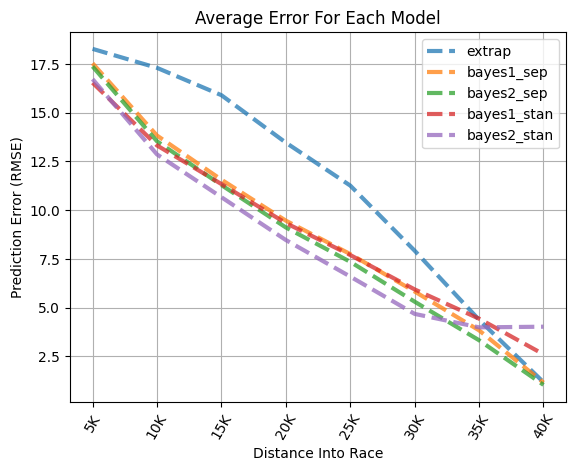

In [9]:
labels = ["extrap", "stan", "stan_sep"]#, "bayes2", "quant1", "quant2"]
labels = ["extrap", "bayes1_sep", "bayes2_sep", "bayes1_stan", "bayes2_stan"]
colors = ["C0", "C1", "C2", "C3", "C4"]
styles = '--'
mks = ["5K", "10K", "15K", "20K", "25K", "30K", "35K", "40K"]
table_group = table.groupby(["dist"])[labels].apply(lambda x: (x ** 2).mean() ** 0.5).loc[mks]
print(table_group)
table_group.plot(label=table_group.columns,  style=styles, linewidth=3, grid=True, alpha=0.75, color=colors)

plt.xlabel("Distance Into Race")
plt.ylabel("Prediction Error (RMSE)")
plt.xticks(rotation=60)
plt.title("Average Error For Each Model")
plt.grid(True)
plt.legend()
# plt.savefig("analysis/all_errors_new1.png", bbox_inches="tight")

In [10]:
full_preds1 =  (42195 / 60) / full_predictions(test, stan_results1, feats_lis = ["total_pace", "prop"], beta_lis = ["beta.1", "beta.2"])
full_preds2 =  (42195 / 60) / full_predictions(test, stan_results2, feats_lis = ["total_pace", "curr_pace", "prop"], beta_lis = ["beta.1", "beta.2", "beta.3"])

full_sep1 =  (42195 / 60) / full_predictions_NEW(test, r_results1, feats_lis = ["total_pace", "prop"], beta_lis = ["beta[1]", "beta[2]"])
full_sep2 =  (42195 / 60) / full_predictions_NEW(test, r_results2, feats_lis = ["total_pace", "curr_pace", "prop"], beta_lis = ["beta[1]", "beta[2]", "beta[3]"])

full_preds1.shape, full_preds2.shape, full_sep1.shape, full_sep2.shape

((6400, 4000), (6400, 4000), (6400, 4000), (6400, 4000))

In [11]:
# (42195/60) / test["finish"]
full_preds1.max(axis=1) - full_preds1.min(axis=1)#.shape

array([ 31.16439906,  34.53798276,  30.87384247, ..., 228.2735921 ,
       193.04432005, 336.81917123])

In [12]:
full_preds1.shape

(6400, 4000)

In [13]:
def add_intervals_to_test(data_tbl, preds1, preds2):#, q1, q2):
    data = data_tbl.copy()
    for conf, lower, upper in [(50, 25, 75), (80, 10, 90), (95, 2.5, 97.5)]:
        test_true = (42195 / 60) / data["finish"]
        b11, b12 = np.percentile(preds1, [lower, upper], axis=1)
        data[f"bayes1-lower{conf}"] = b11
        data[f"bayes1-upper{conf}"] = b12
        data[f"bayes1-size{conf}"] = b12 - b11
        data[f"bayes1-in{conf}"] = (test_true < b12) & (test_true > b11)

        b21, b22 = np.percentile(preds2, [lower, upper], axis=1)
        data[f"bayes2-lower{conf}"] = b21
        data[f"bayes2-upper{conf}"] = b22
        data[f"bayes2-size{conf}"] = b22 - b21
        data[f"bayes2-in{conf}"] = (test_true < b22) & (test_true > b21)

    return data

In [14]:
# table2 = add_intervals_to_test(table, full_preds1, full_preds2)
table2 = add_intervals_to_test(table, full_sep1, full_sep2)
table2

,id,dist,curr_pace,total_pace,finish,age,gender,year,prop,propleft,...,bayes2-size80,bayes2-in80,bayes1-lower95,bayes1-upper95,bayes1-size95,bayes1-in95,bayes2-lower95,bayes2-upper95,bayes2-size95,bayes2-in95
28,286805,5K,5.154639,5.154639,5.018435,31,M,2023,0.118497,0.881503,...,17.735615,True,129.567984,160.487451,30.919467,True,131.059811,158.322052,27.262241,True
71,286848,5K,4.677268,4.677268,4.851115,29,F,2023,0.118497,0.881503,...,21.750967,False,142.167738,180.069998,37.902260,True,143.833627,177.348663,33.515036,True
85,286862,5K,4.897160,4.897160,4.806904,30,M,2023,0.118497,0.881503,...,19.731169,True,136.111239,170.221872,34.110633,True,137.484035,168.383132,30.899097,True
120,286897,5K,5.117707,5.117707,4.720855,41,M,2023,0.118497,0.881503,...,18.306748,True,130.706200,161.216132,30.509931,True,131.925851,160.327130,28.401279,True
125,286902,5K,4.616805,4.616805,4.707687,23,M,2023,0.118497,0.881503,...,22.321660,False,144.244703,182.247307,38.002604,True,145.392272,179.765878,34.373607,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208126,312707,40K,1.631321,1.960977,1.956008,27,F,2023,0.947980,0.052020,...,6.731816,True,354.559389,366.077101,11.517712,True,356.430437,366.601043,10.170606,True
208138,312719,40K,1.728310,1.967439,1.951665,56,F,2023,0.947980,0.052020,...,6.688706,True,353.386409,364.503614,11.117205,True,353.790741,364.084922,10.294181,True
208148,312729,40K,1.693193,1.959728,1.943664,60,M,2023,0.947980,0.052020,...,6.629097,True,354.945638,366.078312,11.132673,True,355.586558,365.787864,10.201306,True
208150,312731,40K,1.431434,1.968310,1.942322,64,M,2023,0.947980,0.052020,...,6.744028,True,353.188490,364.488814,11.300324,True,358.458264,368.711877,10.253614,True


In [15]:
from collections import Counter
Counter(table2["bayes1-in50"])

Counter({True: 3533, False: 2867})

<Figure size 4000x4000 with 0 Axes>

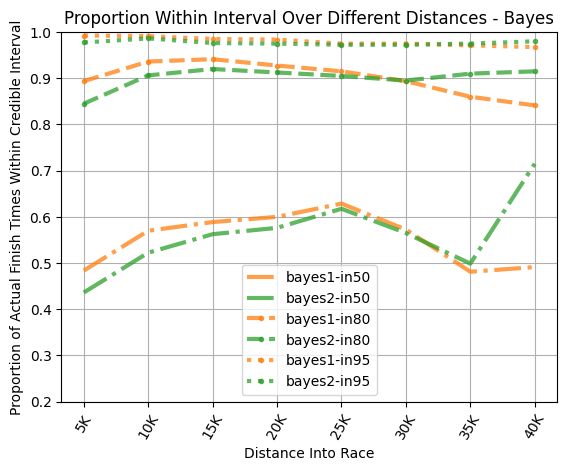

In [16]:
colors = ['C1', 'C2'] * 3
tables = []
for conf, style in [(50, "-."), (80, "--."), (95, ":.")]:
    sublabels = [f"bayes1-in{conf}", f"bayes2-in{conf}"]
    table3 = table2.groupby(["dist"])[sublabels].apply(lambda x: np.sum(x) / len(x)).loc[mks]
    tables.append(table3)

plt.figure(figsize=(40, 40))
big_table = pd.concat(tables, axis=1)
big_table.plot(label=big_table.columns,  style=["-."] * 2 + ["--."] * 2 + [":."] * 2 , linewidth=3, grid=True, alpha=0.75, color=colors)
# plt.ylim(0.2, 1) 
plt.legend(loc="lower center")

plt.xlabel("Distance Into Race")
plt.ylabel("Proportion of Actual Finish Times Within Credible Interval")
plt.xticks(rotation=60)
plt.ylim(0.2, 1)
plt.title("Proportion Within Interval Over Different Distances - Bayes")
plt.grid(True)
plt.legend()
# plt.savefig("analysis/interval_check_bayes.png", bbox_inches="tight")

<Figure size 3000x2000 with 0 Axes>

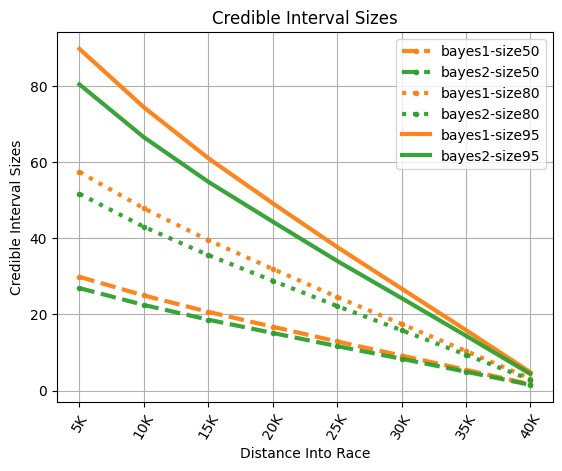

In [17]:
colors = ['C1', 'C2'] * 3
tables = []
for conf, style in [(50, "-."), (80, "--."), (95, ":.")]:
    sublabels = [f"bayes1-size{conf}", f"bayes2-size{conf}"]
    table3 = table2.groupby(["dist"])[sublabels].apply(lambda x: (x ** 2).mean() ** 0.5).loc[mks]
    tables.append(table3)

plt.figure(figsize=(30, 20))
big_table = pd.concat(tables, axis=1)
big_table.plot(label=big_table.columns,  style= ["--."] * 2 + [":."] * 2 , linewidth=3, grid=True, alpha=0.95, color=colors)

plt.xlabel("Distance Into Race")
plt.ylabel("Credible Interval Sizes")
plt.xticks(rotation=60)
plt.title("Credible Interval Sizes")
plt.grid(True)
# plt.savefig("analysis/interval_sizes_bayes.png", bbox_inches="tight")
